If our data is a list of exposure amounts for different substances, then we would need to have some sort of repository that contains the reference values for most substances/our substances of interest. The code will then have to loop through the exposure list and for each exposure, match to the corresponding reference value and then calculate the HQ of that substance. As each HQ is calculated, add it to the HI.

For now, assuming that input data is a list of pairs; i.e., [(substance1, amount1), (substance2, amount2), ...]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### First we clean the IUR values .csv file for ease of use. We also remove the columns of Dataset1 which we are not using as part of the calculations (i.e., socioeco, race, parity...). ONLY RUN ONCE!!!!!



In [ ]:
# Read the existing CSV files into a DataFrame
##dataset1 = pd.read_csv('/content/drive/My Drive/Undergrad/Thesis/Artificial_Dataset_1.csv')
#IUR_Values = pd.read_csv('/content/drive/My Drive/Undergrad/Thesis/IUR_Values.csv')

# Delete the columns you don't need
##dataset1 = dataset1.drop(['socioeco.1', 'socioeco.2','socioeco.3','socioeco.4','race.1','race.2','Birthplace','Parity'], axis=1)
#IUR_Values = IUR_Values.drop(['MW (microgram/mol)', 'IUR (microgram/m3)'], axis=1)

# Save the modified DataFrames back to a CSV file
##dataset1.to_csv('/content/drive/My Drive/Undergrad/Thesis/Artificial_Dataset_1.csv', index=False)
#IUR_Values.to_csv('/content/drive/My Drive/Undergrad/Thesis/IUR_Values.csv', index=False)  # Overwrite the existing file

### Helper Functions

In [ ]:
def get_IUR_value(substance, df):
    search_value = substance
    matching_rows = df.loc[df['Name'] == search_value, 'IUR (ppbv)']

    if not matching_rows.empty:
        corresponding_IUR = matching_rows.values[0]
    else:
        corresponding_IUR = 0  # Default value when no match is found

    return corresponding_IUR


In [ ]:
def get_coeff_value(substance, df):
    search_value = substance
    matching_rows = df.loc[df['Name'] == search_value, 'Coefficient']

    if not matching_rows.empty:
        corresponding_coeff = matching_rows.values[0]
    else:
        corresponding_coeff = 1  # Default value when no match is found

    return corresponding_coeff

In [ ]:
def get_exp_value(substance, df):
    search_value = substance
    matching_rows = df.loc[df['Name'] == search_value, 'Exponent']

    if not matching_rows.empty:
        corresponding_exp = matching_rows.values[0]
    else:
        corresponding_exp = 1  # Default value when no match is found

    return corresponding_exp

### Calculations... Generalized for non-linear aggregation...

In [ ]:
# Read the CSV files into a DataFrame
dataset1 = pd.read_csv('/content/drive/My Drive/Undergrad/Thesis/Artificial_Dataset_1.csv')
IUR_Values = pd.read_csv('/content/drive/My Drive/Undergrad/Thesis/IUR_Values.csv')
Coeff_Exp = pd.read_csv('/content/drive/My Drive/Undergrad/Thesis/Coeff_Exp.csv')

In [ ]:
# Define the risk calculation function
def risk_calculation(row):
  risk = 0
  column_names = list(dataset1.columns)
  substance_list = column_names[1:-1]  # Exclude the first column and the last column (individual and AML outcome)

  for substance in substance_list:
    exposure_amount = get_coeff_value(substance, Coeff_Exp)*((row[substance])**(get_exp_value(substance, Coeff_Exp)))*get_IUR_value(substance, IUR_Values)
    risk += exposure_amount
  return risk

# Apply the calculation to each row
dataset1['Calculated Risk'] = dataset1.apply(risk_calculation, axis=1)

In [ ]:
# Save the resulting DataFrame to a new CSV file
dataset1.to_csv('/content/drive/My Drive/Undergrad/Thesis/Results/NonLinear_GD_lr-0.01_NoInteraction_mse_MaxNorm', index=False)

In [ ]:
# Normalize data by dividing everything by largest value
results = pd.read_csv('/content/drive/My Drive/Undergrad/Thesis/Results/NonLinear_GD_lr-0.01_NoInteraction_mse_MaxNorm')
max_risk = results['Calculated Risk'].max()
results['Normalized Risk'] = results['Calculated Risk'] / max_risk

In [ ]:
# Save the resulting DataFrame to existing results CSV
results.to_csv('/content/drive/My Drive/Undergrad/Thesis/Results/NonLinear_GD_lr-0.01_NoInteraction_mse_MaxNorm', index=False)

### Analysis of Results

In [ ]:
# Load results .csv file
results = pd.read_csv('/content/drive/My Drive/Undergrad/Thesis/Results/NonLinear_GD_lr-0.01_NoInteraction_mse_MaxNorm')

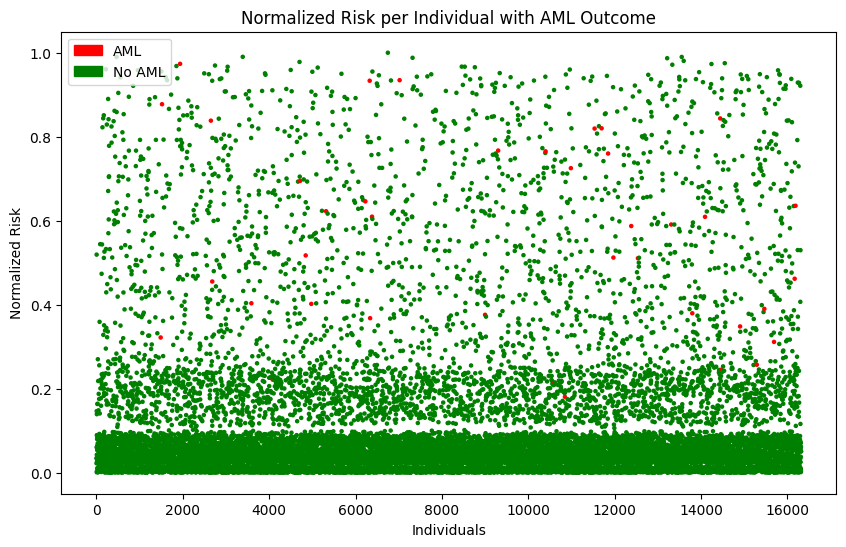

In [ ]:
## SCATTER PLOT FOR NORMALIZED RISK PER INDIVIDUAL (WITH AML OUTCOME)

# Create a list of colors based on "AML Outcome"
colors = ['red' if outcome == 1 else 'green' for outcome in results['AMLoutcome']]

# Plot the scatter plot
plt.figure(figsize=(10, 6))  # Set the figure size

# Create the scatter plot
plt.scatter(results['Individual'], results['Normalized Risk'], color=colors, s=5)

# Add labels and title
plt.xlabel('Individuals')
plt.ylabel('Normalized Risk')
plt.title('Normalized Risk per Individual with AML Outcome')

# Optionally, add a legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', edgecolor='r', label='AML'),
                   Patch(facecolor='green', edgecolor='g', label='No AML')]
plt.legend(handles=legend_elements)

# Show the plot
plt.show()

<ipython-input-26-fe0db6212d42>:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(x_axis, rotation=45, ha='right')
<ipython-input-26-fe0db6212d42>:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(x_axis, rotation=45, ha='right')


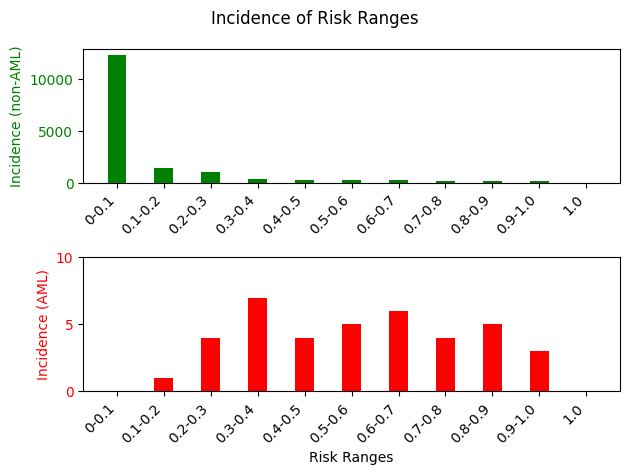

In [ ]:
# GRAPHS TO VISUALIZE RISKS WITH HIGHEST INCIDENCE FOR BOTH AML POSITIVE/NEGATIVE

###### INCIDENCE ARRAY FOR NON-AML

# Filter the DataFrame to include only rows where "AML Outcome" = 0
aml_negative = results[results['AMLoutcome'] == 0]

# Create list with 11 zeros
risk_incidence_negative = [0] * 11

# Loop to determine incidence of risks (risk increments of 0.1) for AML negative
list_index = 0
for i in range(0,11,1):
  for risk in aml_negative['Normalized Risk']:
    if risk >= i/10 and risk < i/10 + 0.1:
      risk_incidence_negative[list_index] += 1
  list_index += 1

np.array(risk_incidence_negative)

###### INCIDENCE ARRAY FOR AML

# Filter the DataFrame to include only rows where "AML Outcome" = 1
aml_positive = results[results['AMLoutcome'] == 1]

# Create list with 11 zeros
risk_incidence_positive = [0] * 11

# Loop to determine incidence of risks (risk increments of 0.1) for AML positive
list_index = 0
for i in range(0,11,1): #range to 1.01 so that 1 is included
  for risk in aml_positive['Normalized Risk']:
    if risk >= i/10 and risk < i/10 + 0.1:
      risk_incidence_positive[list_index] += 1
  list_index += 1

np.array(risk_incidence_positive)

###### X-AXIS

# Create x-axis
x_axis = ['0-0.1','0.1-0.2','0.2-0.3','0.3-0.4','0.4-0.5','0.5-0.6','0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0','1.0']
x_axis = np.array(x_axis)

###### PLOTTING

fig, (ax1,ax2) = plt.subplots(2)

ax1.set_ylabel('Incidence (non-AML)', color='g')
ax1.bar(x_axis, risk_incidence_negative, width = 0.4, color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.set_xticklabels(x_axis, rotation=45, ha='right')

ax2.set_xlabel('Risk Ranges')
ax2.set_ylabel('Incidence (AML)', color='r')
ax2.bar(x_axis, risk_incidence_positive, width = 0.4, color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_xticklabels(x_axis, rotation=45, ha='right')
ax2.set_yticks([0,5,10])

fig.suptitle('Incidence of Risk Ranges')
fig.tight_layout()
plt.show()

######

In [ ]:
# PERCENT OF AML POSITIVE VS AML NEGATIVE ABOVE 0.3 NORMALIZED RISK

# Filter the DataFrame to include only rows where "AML Outcome" = 1
aml_positive = results[results['AMLoutcome'] == 1]

# Filter the DataFrame to include only rows where "AML Outcome" = 0
aml_negative = results[results['AMLoutcome'] == 0]

positive_over_03 = (aml_positive['Normalized Risk'] > 0.3).sum()
negative_over_03 = (aml_negative['Normalized Risk'] > 0.3).sum()

print("Percentage of AML Positive Individuals with Normalised Risk > 0.3:", (positive_over_03 / len(aml_positive))*100)
print("Percentage of AML Negative Individuals with Normalised Risk > 0.3:", (negative_over_03 / len(aml_negative))*100)

Percentage of AML Positive Individuals with Normalised Risk > 0.3: 87.17948717948718
Percentage of AML Negative Individuals with Normalised Risk > 0.3: 9.815724815724817


<ipython-input-28-d82f5173d70c>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_axis, rotation=45, ha='right')


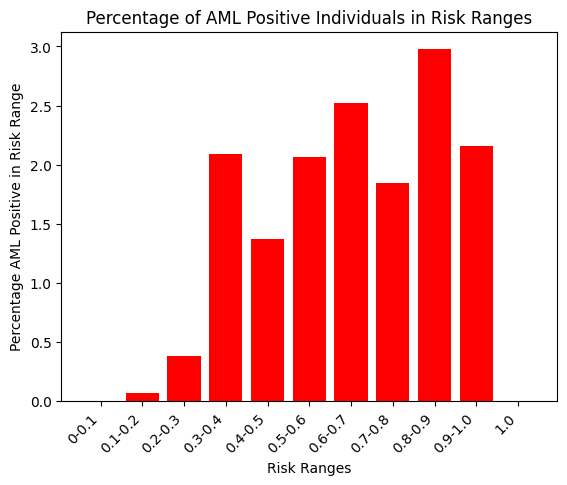

In [ ]:
# Dividing each AML positive risk range by total in risk range
total_risk_incidence = np.array(risk_incidence_positive) + np.array(risk_incidence_negative)
percent_risk_incidence_positive = risk_incidence_positive / total_risk_incidence *100

plt.bar(x_axis, percent_risk_incidence_positive, width = 0.8, color='r')
ax = plt.gca()
ax.set_xticklabels(x_axis, rotation=45, ha='right')
ax.set_xlabel('Risk Ranges')
ax.set_ylabel('Percentage AML Positive in Risk Range')
plt.title('Percentage of AML Positive Individuals in Risk Ranges')
plt.show()